### Introduction


The global cancer burden is estimated to have risen to 18.1 million new cases and 9.6 million deaths in 2018. One in 5 men and one in 6 women worldwide develop cancer during their lifetime, and one in 8 men and one in 11 women die from the disease.
The clinical radiologists and radiation oncologists who treat cancers have catheters and lines inserted during the course of emergency  in the patients during treatment. If not positioned correctly they can lead to serious complications

The dataset consist of insertion of 3 catheters

**Endotracheal tube**-An endotracheal tube is a flexible plastic tube that is placed through the mouth into the trachea (windpipe) to help a patient breathe. 

**Nasogastric tube**-A nasogastric  tube is a flexible tube of rubber or plastic that is passed through the nose, down through the esophagus, and into the stomach.

**Central Venous Catheter**-A central venous catheter is a thin, flexible tube that is inserted into a vein, usually below the right collarbone, and guided (threaded) into a large vein above the right side of the heart called the superior vena cava.


What we need to do? 
We will detect the presence and position of catheters and lines on chest x-rays i.e we will predict predict a probability of the tube  placed in a Normal position ,Abnormal Position, Boarderline.

 Metric: Area Under the ROC curve

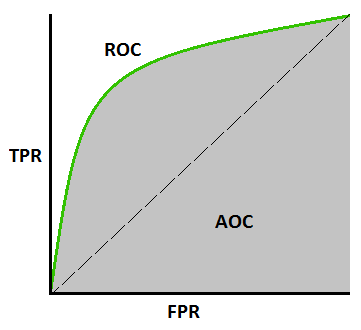

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Import the Libraries

In [ ]:
import os
from os import listdir
import pandas as pd
import numpy as np
import glob
import tqdm
from typing import Dict
import matplotlib.pyplot as plt

%matplotlib inline



from colorama import Fore, Back, Style
#plotly
!pip install chart_studio
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

from colorama import Fore, Back, Style

import seaborn as sns
sns.set(style="whitegrid")
import pydicom
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.show()


In [ ]:
train=pd.read_csv('../input/ranzcr-clip-catheter-line-classification/train.csv')

In [ ]:
train.head()

### Columns
StudyInstanceUID - unique ID for each image

ETT - Abnormal - endotracheal tube placement abnormal

ETT - Borderline - endotracheal tube placement borderline abnormal

ETT - Normal - endotracheal tube placement normal

NGT - Abnormal - nasogastric tube placement abnormal

NGT - Borderline - nasogastric tube placement borderline abnormal

NGT - Incompletely Imaged - nasogastric tube placement inconclusive due to imaging

NGT - Normal - nasogastric tube placement borderline normal

CVC - Abnormal - central venous catheter placement abnormal

CVC - Borderline - central venous catheter placement borderline abnormal

CVC - Normal - central venous catheter placement normal

Swan Ganz Catheter Present

PatientID - unique ID for each patient in the dataset

In [ ]:
print(Fore.YELLOW + 'Training data shape: ',Style.RESET_ALL,train.shape)
train.head(5)

In [ ]:
train.info()

In [ ]:
labels = train[train.columns[1:-1]].columns.tolist()

In [ ]:
train.iloc[:, :-1].sum()[1:]

In [ ]:
train.isnull().sum()

In [ ]:
plt = px.bar(train.iloc[:, :-1].sum()[1:],x=labels,y=np.sum(train[labels]), template = 'seaborn',title="Positions of Tube")

plt.show()

In [ ]:
print(Fore.YELLOW +"Total Patients in Train set: ",Style.RESET_ALL,train['PatientID'].count())

In [ ]:
print(Fore.YELLOW + "The total patient ids are",Style.RESET_ALL,f"{train['PatientID'].count()},", Fore.BLUE + "from those the unique ids are", Style.RESET_ALL, f"{train['PatientID'].value_counts().shape[0]}.")

In [ ]:
ETT = ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal']
NGT = ['NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal']
CVC = ['CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal']

In [ ]:
train[ETT].sum(axis=1).value_counts().iplot(kind='bar',
                                              yTitle='Counts', 
                                              linecolor='black', 
                                              opacity=0.7,
                                              color='RED',
                                              theme='pearl',
                                              bargap=0.5,
                                              gridcolor='white',
                                              title='Distribution of ETT')

In [ ]:
train[NGT].sum(axis=1).value_counts().iplot(kind='bar',
                                              yTitle='Counts', 
                                              linecolor='black', 
                                              opacity=0.7,
                                              color='RED',
                                              theme='pearl',
                                              bargap=0.5,
                                              gridcolor='white',
                                              title='Distribution of NGT')

In [ ]:
train[CVC].sum(axis=1).value_counts().iplot(kind='bar',
                                              yTitle='Counts', 
                                              linecolor='black', 
                                              opacity=0.7,
                                              color='blue',
                                              theme='pearl',
                                              bargap=0.5,
                                              gridcolor='white',
                                              title='Distribution of CVC')

### Lets Look at some images

In [ ]:
train_annot=pd.read_csv("../input/ranzcr-clip-catheter-line-classification/train_annotations.csv")

In [ ]:
train_annot.head()

In [ ]:
path='../input/ranzcr-clip-catheter-line-classification/'
def plot(data, imageclass):
    
    fig, ax = plt.subplots(1, 2, figsize = (25,12))
    temp = data[data[imageclass]==1]
    
    for i in range(2):
        idx = temp.index[i]
        image_id = temp.loc[idx, 'StudyInstanceUID']
        image_file = cv2.imread(''.join([path, 'train/', image_id, '.jpg']))
        image_file = cv2.cvtColor(image_file, cv2.COLOR_BGR2RGB)
        ax[i].imshow(image_file)
        ax[i].set_title(imageclass)
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])

In [ ]:

plot(train, 'ETT - Abnormal')

In [ ]:
plot(train, 'NGT - Abnormal')

In [ ]:
plot(train, 'CVC - Borderline')

In [ ]:
plot(train, 'Swan Ganz Catheter Present')

### To be continued